In [1]:
import torch
import torch.nn as nn


def create_model(n_classes: int = 512) -> nn.Module:
    """Creates a new CNN.

    Creates a new pytorch neural network that models the audio cortex
    using the architecture presented by Josh McDermmott. One key difference
    is that batch normalization in this model occurs over the whole minibatch
    instead of the original 5 adjacent, zero-padded convolution window.

    Args:
    ----
        n_classes: The number of classes the model should output to.

    Returns:
    -------
        A CNN model following Josh McDermmott's architecture.

    """
    return nn.Sequential(
        nn.Conv2d(1, out_channels=96, kernel_size=9, stride=3, padding=3),
        nn.ReLU(),
        nn.BatchNorm2d(96), # McDermmott does normalization differently*
        nn.AvgPool2d(3, stride=2),
        nn.Conv2d(96, out_channels=256, kernel_size=5, stride=2, padding=3),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.AvgPool2d(3, stride=2, padding=1),
        nn.Conv2d(256, out_channels=512, kernel_size=3, stride=1, padding=2),
        nn.Conv2d(512, out_channels=1024, kernel_size=3, stride=1, padding=2),
        nn.Conv2d(1024, out_channels=512, kernel_size=3, stride=1, padding=2),
        nn.AvgPool2d(3, stride=2),
        nn.Flatten(),
        nn.Linear(8*8*512, 4096),
        nn.Dropout(0.5),
        nn.Linear(4096, n_classes),
        nn.Softmax(dim=-1))

model = create_model()
X = torch.randn(1, 1, 256, 256)
out = model(X)
out.shape

torch.Size([1, 512])

In [2]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

optim = AdamW(model.parameters())
loss_fn = CrossEntropyLoss()

In [4]:
from typing import List, Optional, Tuple

from sklearn.model_selection import ShuffleSplit


def cv_sets(data: torch.Tensor, k: int = 10, test_size: float = 0.2,
            random_seed: Optional[int] = None
            ) -> List[Tuple[List[int], List[int]]]:
    """Generate cross-validation datasets.

    Using scikit-learn's
    [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

    Args:
    ----
        data: The data set to split upon.
        k: Number of folds.
        test_size: A float representing the portion of data to split into test.
        random_seed: An integer for the random seed used to split the set.

    Returns:
    -------
        A list of `k` tuples, each tuple containing lists of train indices and
        test indices.

    """
    rs = ShuffleSplit(n_splits=k, random_state=random_seed, test_size=test_size)
    return rs.split(data)

In [35]:
import math
from datetime import datetime

import numpy as np


def batcherize(X_set: torch.Tensor, y_set: torch.Tensor, indices: List[int],
               batch_size: int) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    """Split model into batches given a list of indices.

    Args:
    ----
        X_set: A tensor for the input data into the model.
        y_set: A tensor for the output data that the model learns to fit.
        indices: A list of indices to create minibatches from.
        batch_size: An integer batch size.

    Returns:
    -------
        A list of ceil(len(indices) / batch_size) to enumerate over, where each
        element is a subset of the training input/target, split in the order
        given by the indices argument.

    """
    batches = []
    n = math.ceil(len(indices) / batch_size)
    for i in range(n):
        start_ix = i * batch_size
        idx = indices[start_ix:start_ix + batch_size]
        batches.append(
            (X_set[idx], y_set[idx])
        )
    return batches

def train(model: nn.Module, epochs: int, X_train: torch.Tensor,
          y_train: torch.Tensor, optim: torch.optim.Optimizer, loss_fn: any,
          k: int = 10, bs: int = 16, test_size: float = 0.2
          ) -> Tuple[List[float], List[float]]:
    """Train a model given parameters.

    Args:
    ----
        model: A model instance to be trained.
        epochs: The number of epochs to train for.
        X_train: A pytorch tensor for the data to train on as input to the
            model.
        y_train: A pytorch tensor representing logits (indices) that the model
            should output, corresponding to the input X_train.
        optim: A pytorch optimizer for stepping the gradients.
        loss_fn: The loss function to which the model is optimizing for,
            typically CrossEntropyLoss for classification.
        k: An integer number of folds for cross-validation training.
        bs: The batch size for parallelization of training.
        test_size: A decimal value for train/valid split used for the cross
            validation splitting.

    Returns:
    -------
        A tuple containing two lists, each the training and validation loss
        respectively, over all epochs of training.

    """
    N = X_train.shape[0]
    N_train = math.ceil((N * (1 - test_size)) / bs)
    N_test = math.ceil((N * test_size) / bs)
    print('Starting training.')
    print(f'Number of minibatches for training/test: {N_train}/{N_test}')
    t_losses = []
    v_losses = []
    for e in range(epochs):
        print(f'Starting epoch {e+1} of {epochs}')
        cv_splits = cv_sets(X_train, k, 0.2, None)

        starttime = datetime.now()
        batch_tl = [] # batch train losses
        batch_vl = []
        for i, (train_ix, valid_ix) in enumerate(cv_splits):
            train_batches = batcherize(X_train, y_train, train_ix, bs)
            valid_batches = batcherize(X_train, y_train, valid_ix, bs)
            model.train()
            for inputs, targets in train_batches:
                optim.zero_grad()
                out = model(inputs)
                loss = loss_fn(out, targets)
                loss.backward()
                optim.step()
                batch_tl.append(loss.item())
            model.eval()
            for inputs, targets in valid_batches:
                out = model(inputs)
                loss = loss_fn(out, targets)
                batch_vl.append(loss.item())

        t_loss = np.mean(batch_tl)
        t_losses.append(t_loss)
        v_losses.append(np.mean(batch_vl))
        secs_elapsed = (datetime.now() - starttime).total_seconds()
        print(f'\tTraining took: {secs_elapsed:0.2f}s\twith loss: {t_loss:0.6f}')
    return t_losses, v_losses

In [37]:
N = 40
x_rand = torch.randn((N, 1, 256, 256))
y_rand = torch.randint(512, (N,))
x_rand.shape, y_rand[:3]

(torch.Size([40, 1, 256, 256]), tensor([ 86, 194, 283]))

In [38]:
import random

random.seed(123)

model = create_model()
tl, vl = train(model, 15, x_rand, y_rand, optim, loss_fn)

Starting training.
Number of minibatches for training/test: 2/1
Starting epoch 1 of 15
	Training took: 12.72s	with loss: 6.238327
Starting epoch 2 of 15
	Training took: 12.97s	with loss: 6.238326
Starting epoch 3 of 15
	Training took: 13.35s	with loss: 6.238325
Starting epoch 4 of 15
	Training took: 13.66s	with loss: 6.238324
Starting epoch 5 of 15
	Training took: 13.67s	with loss: 6.238325
Starting epoch 6 of 15
	Training took: 13.63s	with loss: 6.238326
Starting epoch 7 of 15
	Training took: 13.78s	with loss: 6.238326
Starting epoch 8 of 15
	Training took: 13.69s	with loss: 6.238326
Starting epoch 9 of 15
	Training took: 13.63s	with loss: 6.238326
Starting epoch 10 of 15
	Training took: 13.73s	with loss: 6.238326
Starting epoch 11 of 15
	Training took: 13.98s	with loss: 6.238324
Starting epoch 12 of 15
	Training took: 25.50s	with loss: 6.238325
Starting epoch 13 of 15
	Training took: 39.82s	with loss: 6.238326
Starting epoch 14 of 15
	Training took: 21.44s	with loss: 6.238326
Startin

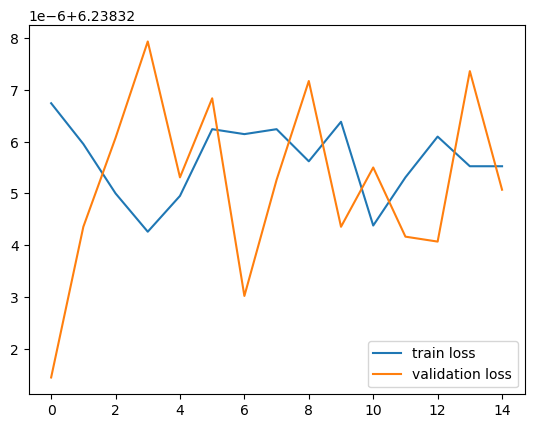

In [39]:
import matplotlib.pyplot as plt

ax = plt.subplot()
ax.plot(np.arange(15), tl, label='train loss')
ax.plot(np.arange(15), vl, label='validation loss')
plt.legend()